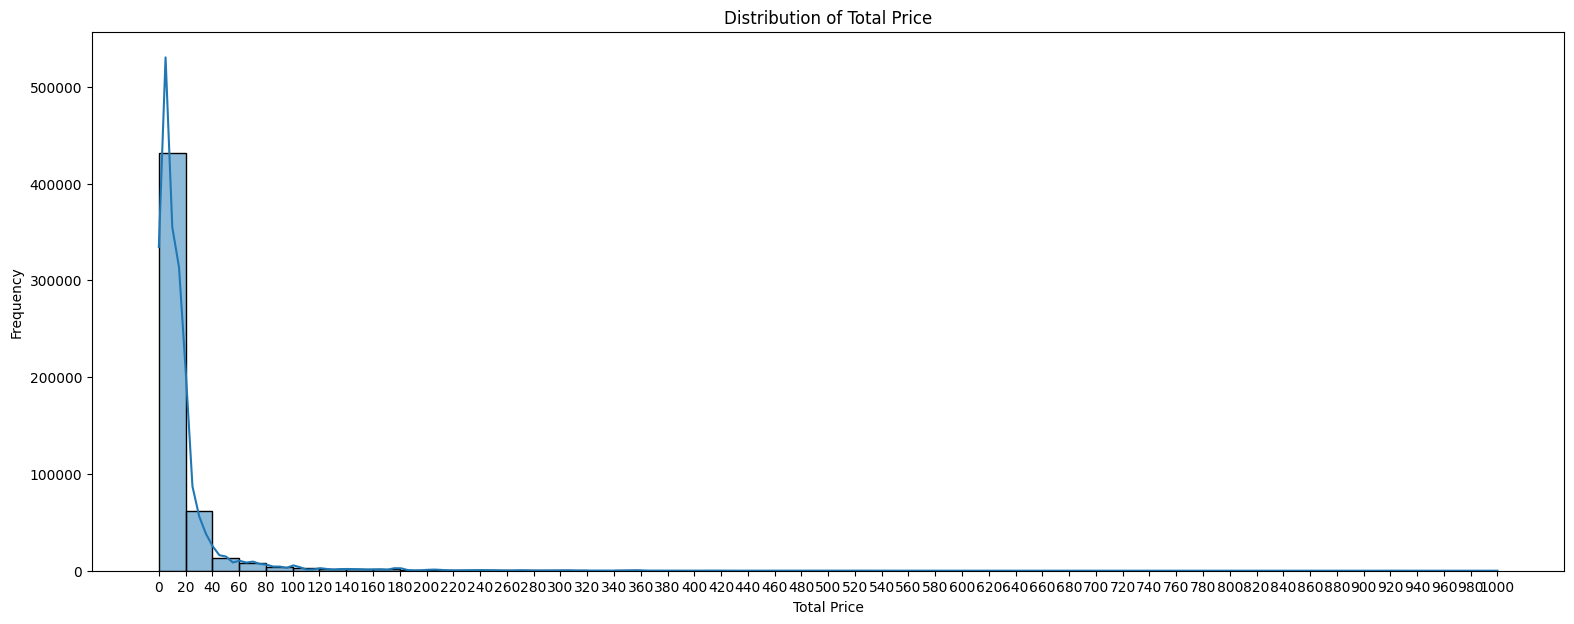

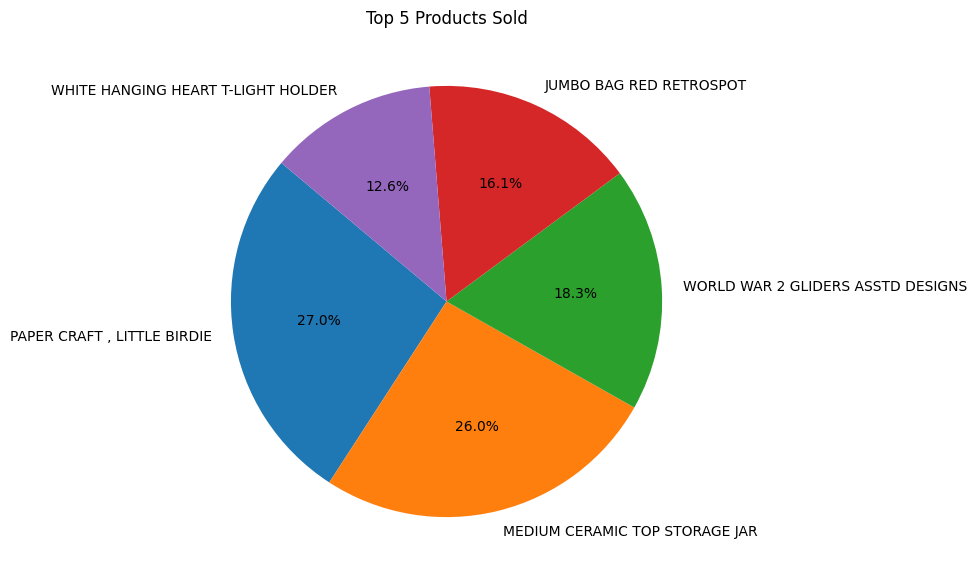

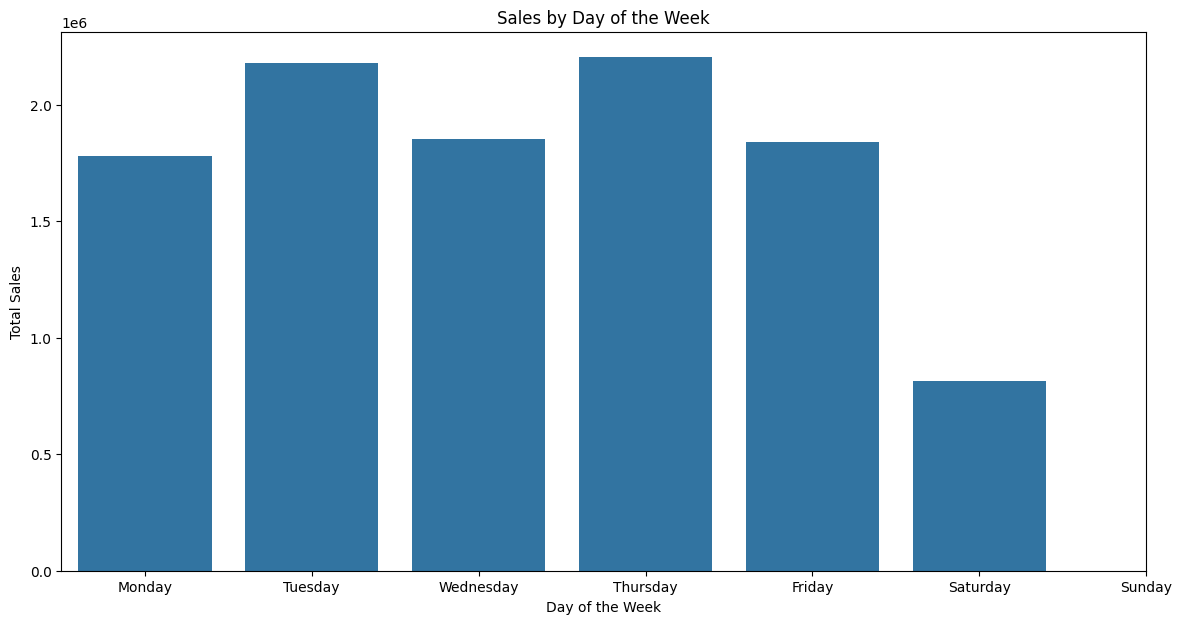

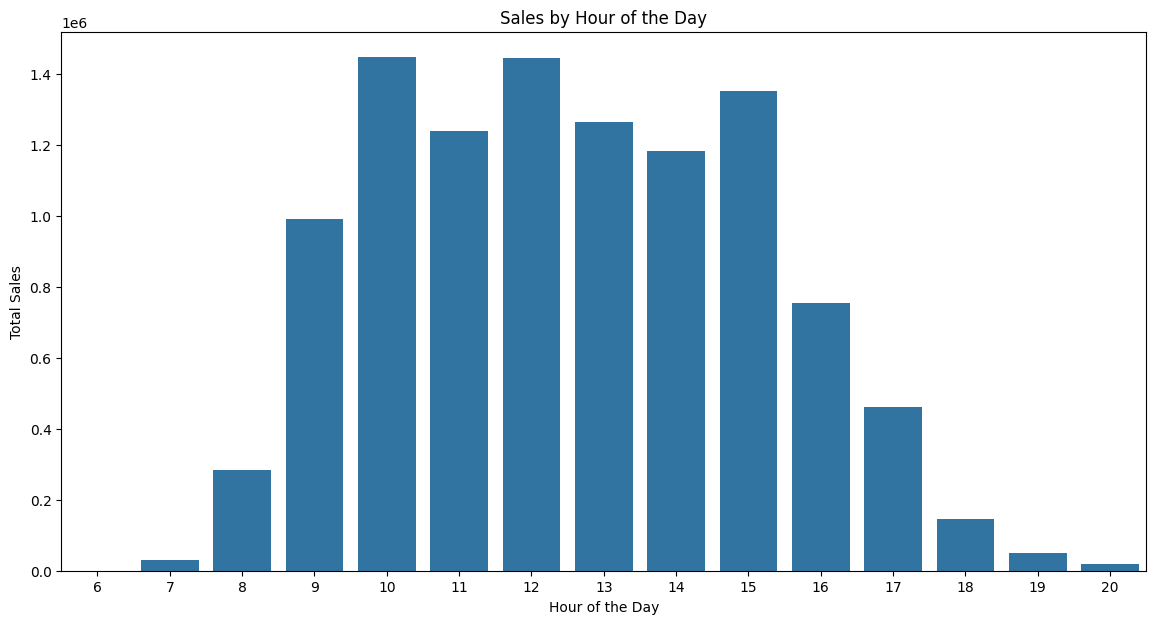

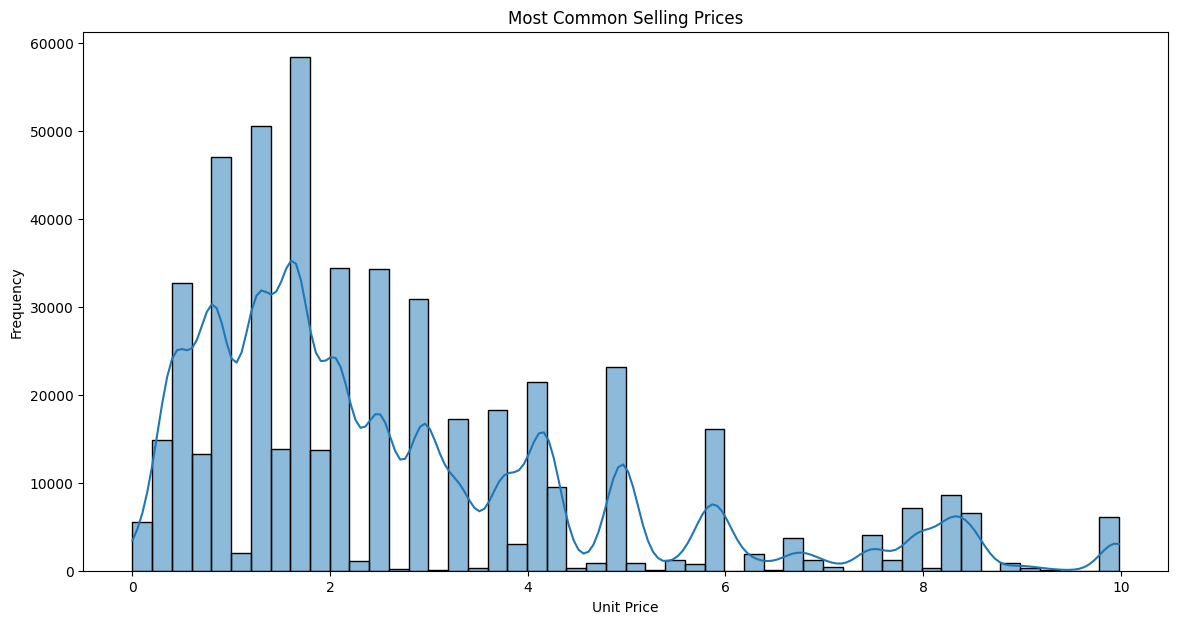

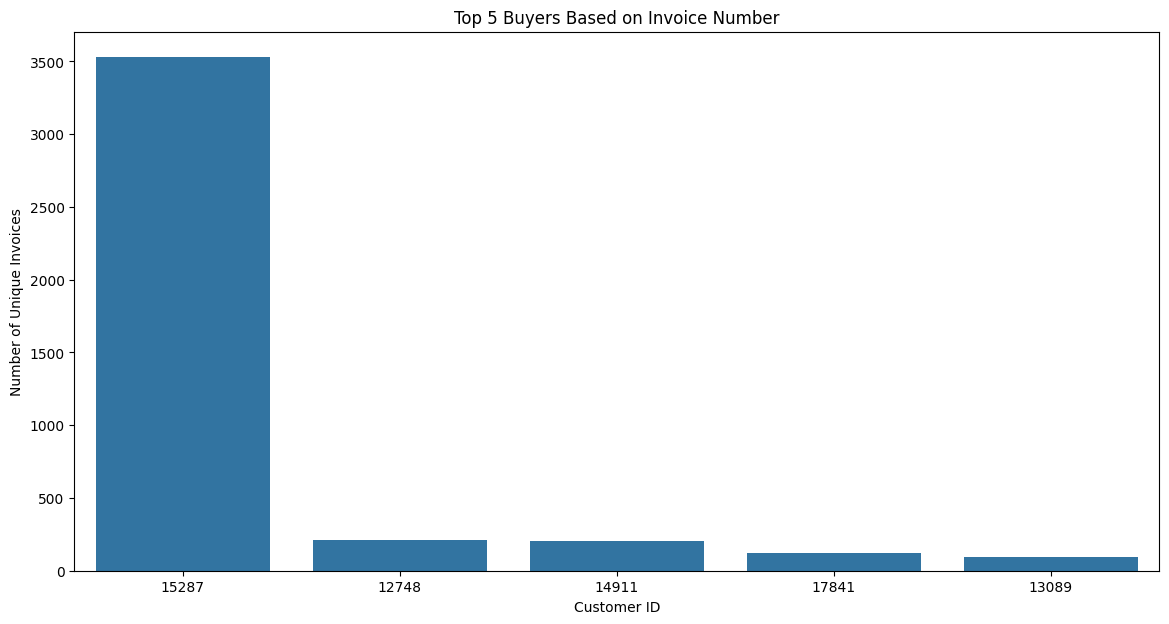

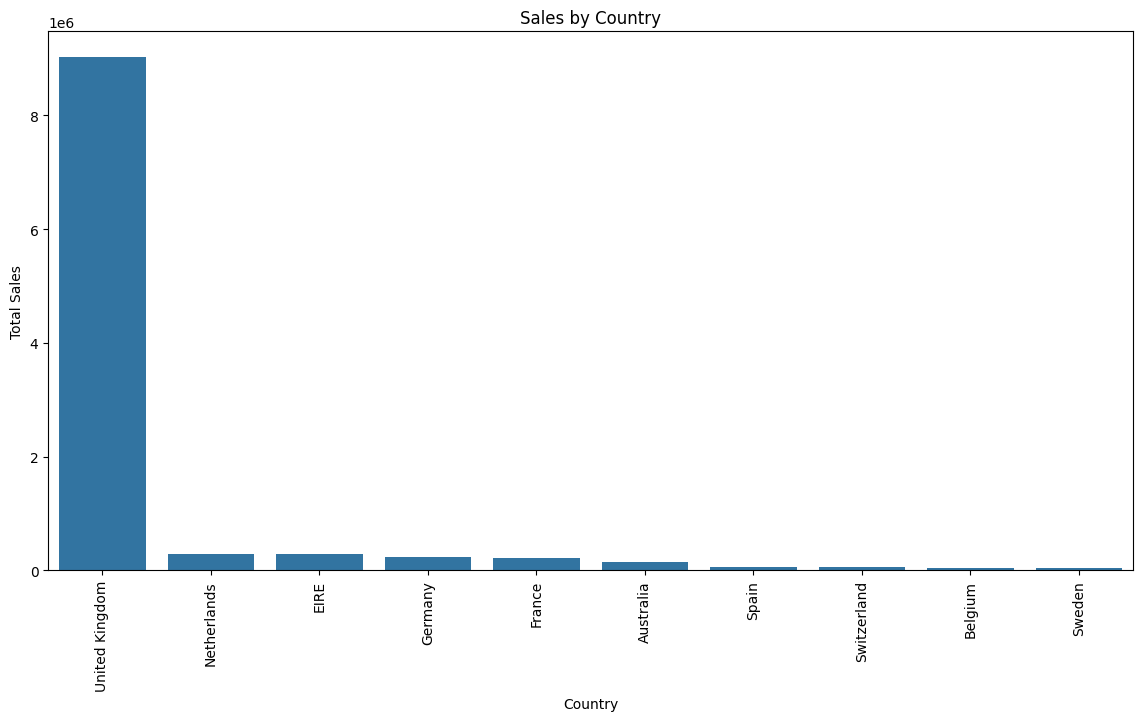

Decision Tree Classifier
Accuracy: 0.9999907580835962
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    324566
         1.0       0.93      1.00      0.97        42

    accuracy                           1.00    324608
   macro avg       0.97      1.00      0.98    324608
weighted avg       1.00      1.00      1.00    324608

Confusion Matrix:
 [[324563      3]
 [     0     42]]
Precision: 0.9333333333333333, Recall: 1.0, F1 Score: 0.9655172413793104
MSE: 9.241916403785489e-06, RMSE: 0.003040052039650882, MAE: 9.241916403785489e-06
     StockCode  CurrentStock  AvgDailySales  TotalQuantitySold  \
3       10123C           -13      -3.250000                -13   
55      16162L            -4      -0.444444                 -4   
56      16162M           -26      -3.714286                -26   
62      16169P           -25      -8.333333                -25   
118     18097A           -18      -4.500000            

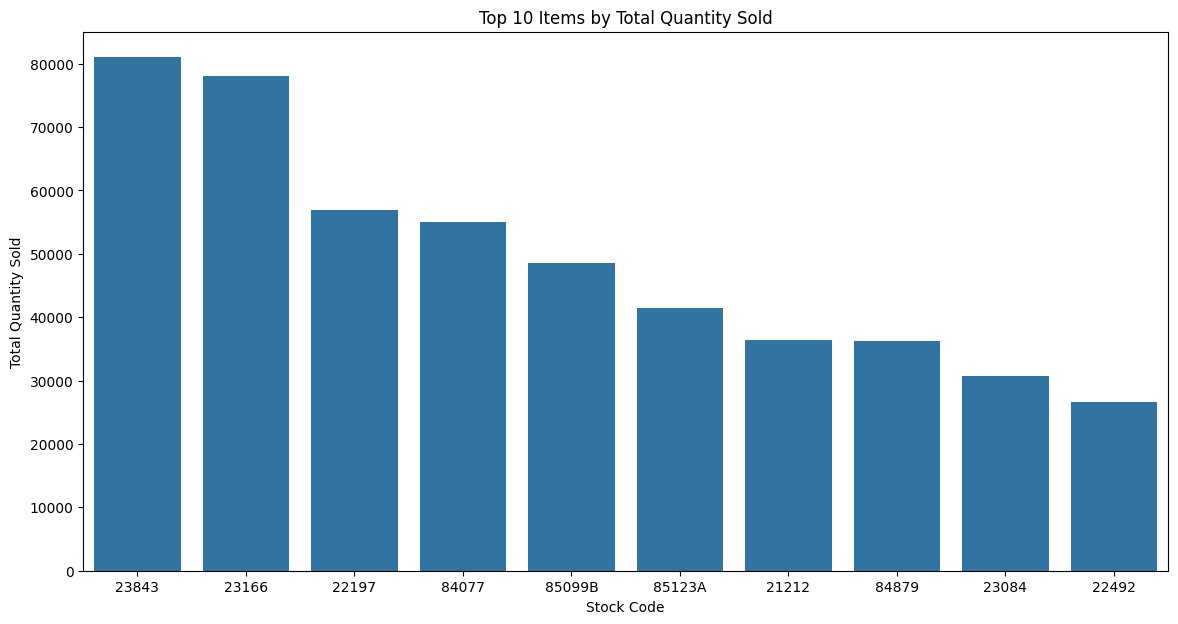

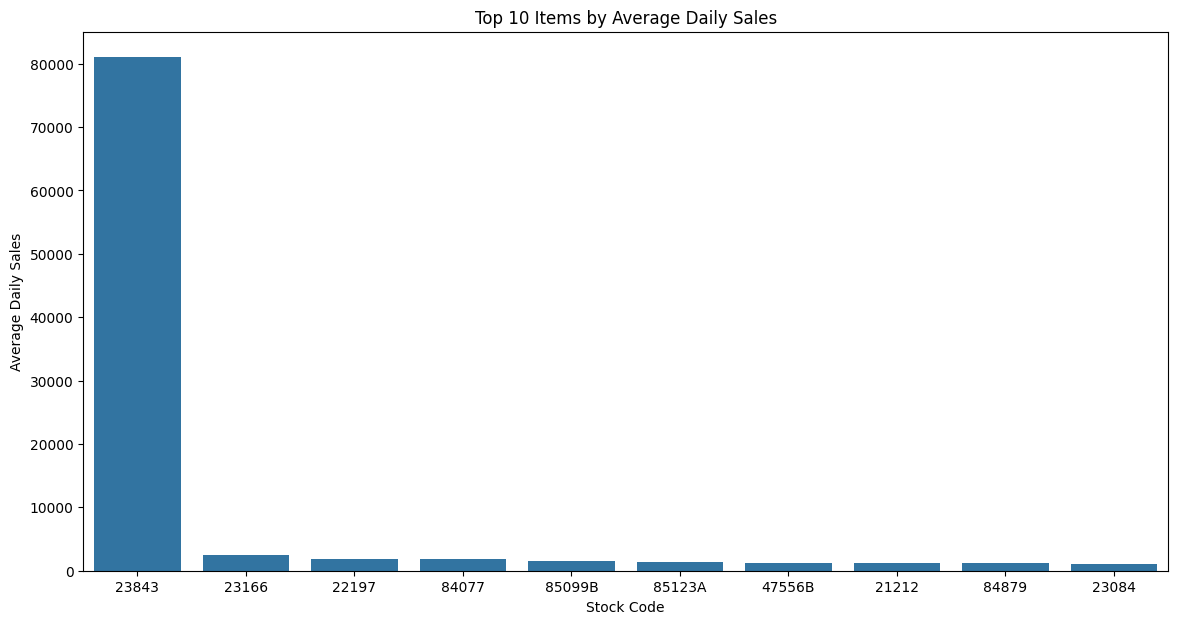

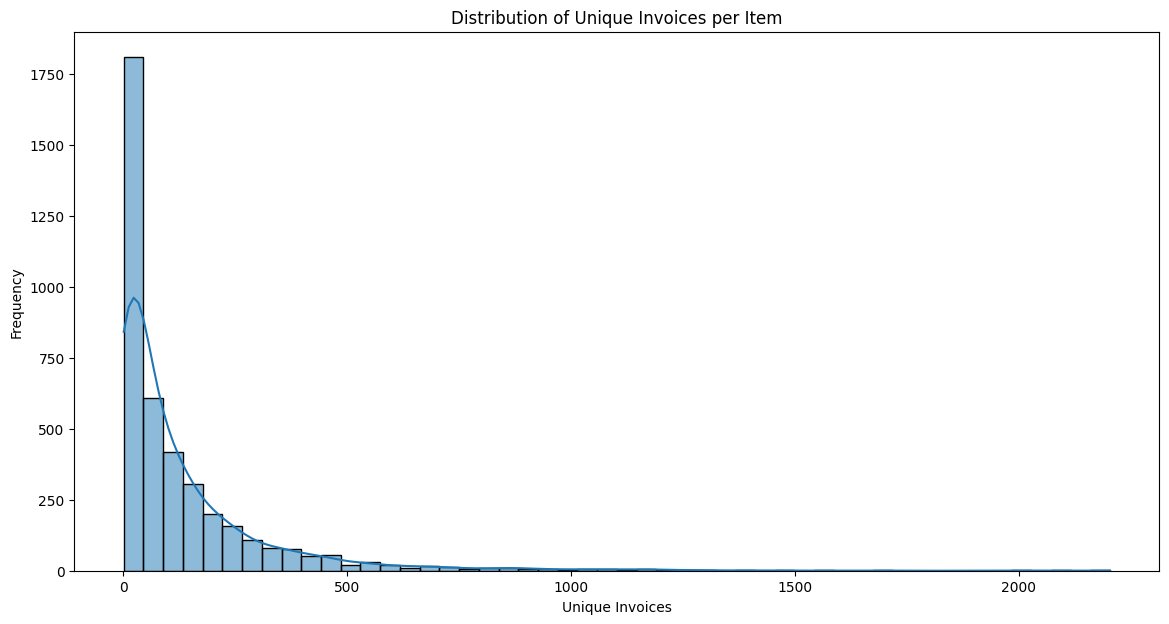

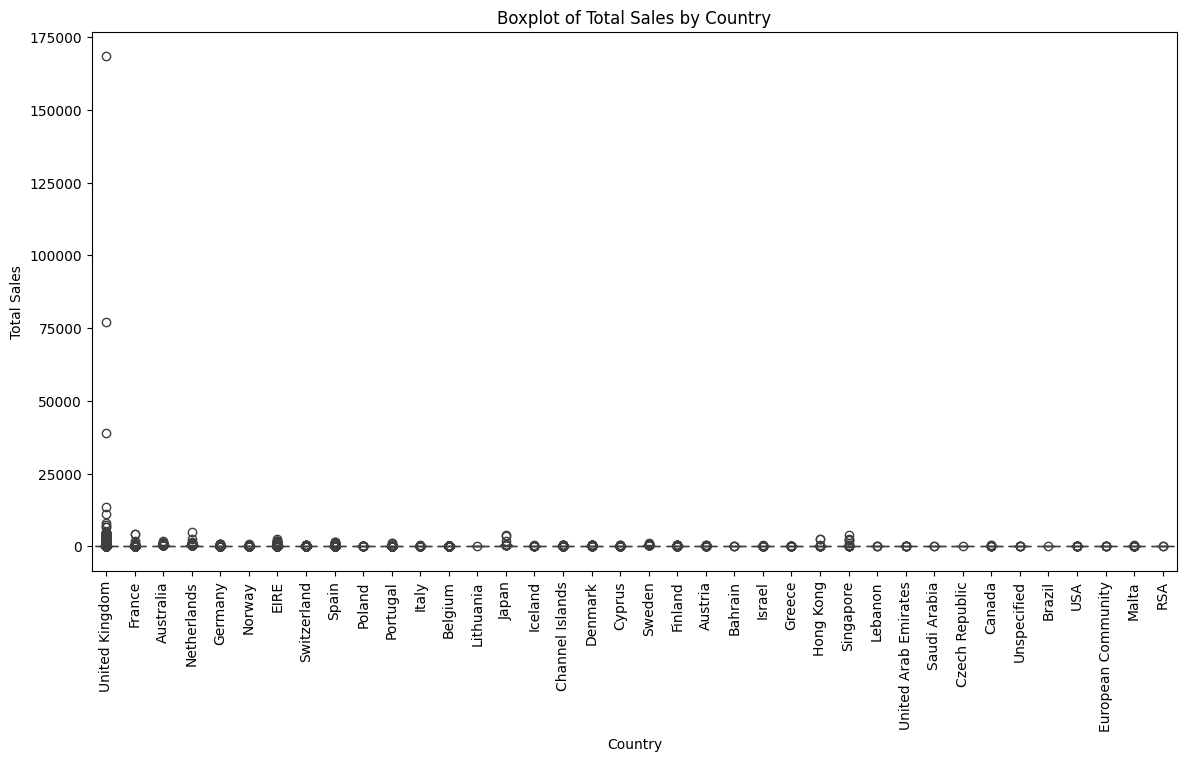

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error, mean_absolute_error

# Data Loading and Preprocessing
data = pd.read_csv('Online Retail.csv')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.dropna(subset=['CustomerID'], inplace=True)
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
data = data[data['TotalPrice'] >= 0]  # Remove negative prices

# Feature Engineering
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['Hour'] = data['InvoiceDate'].dt.hour
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6

# Encode categorical variables
label_encoder = LabelEncoder()
data['CountryEncoded'] = label_encoder.fit_transform(data['Country'])

# Aggregating data at the customer level
customer_data = data.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'InvoiceNo': 'nunique',
    'StockCode': 'nunique',
    'Year': 'nunique',
    'Month': 'nunique',
    'Day': 'nunique',
    'Hour': 'nunique',
    'CountryEncoded': 'first'
}).reset_index()

# Renaming columns for clarity
customer_data.columns = ['CustomerID', 'TotalSpent', 'UniqueInvoices', 'UniqueProducts',
                        'UniqueYears', 'UniqueMonths', 'UniqueDays', 'UniqueHours', 'Country']

# Exploratory Data Analysis (EDA)
filtered_data = data[data['TotalPrice'] <= 1000]

# Distribution of Total Price
plt.figure(figsize=(19, 7))
sns.histplot(filtered_data['TotalPrice'], bins=50, kde=True)
plt.title('Distribution of Total Price')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1001, 20))
plt.show()

# Top 5 Products Sold
top_products = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(14, 7))
plt.pie(top_products, labels=top_products.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Products Sold')
plt.show()

# Sales by Day of the Week
sales_by_day = data.groupby('DayOfWeek')['TotalPrice'].sum()
plt.figure(figsize=(14, 7))
sns.barplot(x=sales_by_day.index, y=sales_by_day.values)
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(ticks=np.arange(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

# Sales by Hour of the Day
sales_by_hour = data.groupby('Hour')['TotalPrice'].sum()
plt.figure(figsize=(14, 7))
sns.barplot(x=sales_by_hour.index, y=sales_by_hour.values)
plt.title('Sales by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Sales')
plt.show()

# Most Common Selling Prices
plt.figure(figsize=(14, 7))
sns.histplot(data[data['UnitPrice'] < 10]['UnitPrice'], bins=50, kde=True)
plt.title('Most Common Selling Prices')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()

# Top 5 Buyers Based on Invoice Number
top_buyers = data.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(5)
plt.figure(figsize=(14, 7))
sns.barplot(x=top_buyers.index.astype(str), y=top_buyers.values)
plt.title('Top 5 Buyers Based on Invoice Number')
plt.xlabel('Customer ID')
plt.ylabel('Number of Unique Invoices')
plt.show()

# Sales by Country
sales_by_country = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 7))
sns.barplot(x=sales_by_country.index, y=sales_by_country.values)
plt.title('Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

# Modeling: Predict if a customer will make a purchase on a given day
data['Purchase'] = 1

# Creating a dataset with all days in the range of the data for each customer
all_days = pd.date_range(start=data['InvoiceDate'].min(), end=data['InvoiceDate'].max(), freq='D')
customers = data['CustomerID'].unique()

all_data = []
for customer in customers:
    for day in all_days:
        all_data.append([customer, day])

all_data = pd.DataFrame(all_data, columns=['CustomerID', 'InvoiceDate'])

# Merging with the original data to find purchases made on each day
all_data = all_data.merge(data[['CustomerID', 'InvoiceDate', 'Purchase']], on=['CustomerID', 'InvoiceDate'], how='left')
all_data['Purchase'].fillna(0, inplace=True)

# Feature Engineering on the new dataset
all_data['Year'] = all_data['InvoiceDate'].dt.year
all_data['Month'] = all_data['InvoiceDate'].dt.month
all_data['Day'] = all_data['InvoiceDate'].dt.day
all_data['DayOfWeek'] = all_data['InvoiceDate'].dt.dayofweek

# Merging with customer data to add aggregated features
final_data = all_data.merge(customer_data, on='CustomerID', how='left')

# Preparing features and target variable
X = final_data.drop(columns=['CustomerID', 'InvoiceDate', 'Purchase'])
y = final_data['Purchase']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred = dt_model.predict(X_test_scaled)

# Evaluation Metrics for Decision Tree
print("Decision Tree Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# RMSE, MSE, MAE for Decision Tree
mse_dt = mean_squared_error(y_test, y_pred)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse_dt}, RMSE: {rmse_dt}, MAE: {mae_dt}")

# Additional Feature: Predict which item stock would get over and need a refill
# Aggregating data at the item (StockCode) level
item_data = data.groupby('StockCode').agg({
    'Quantity': 'sum',
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum',
    'Year': 'nunique',
    'Month': 'nunique',
    'Day': 'nunique',
    'Hour': 'nunique'
}).reset_index()

# Renaming columns for clarity
item_data.columns = ['StockCode', 'TotalQuantitySold', 'UniqueInvoices', 'TotalSales',
                    'UniqueYears', 'UniqueMonths', 'UniqueDays', 'UniqueHours']

# Determining the average daily sales for each item
item_data['AvgDailySales'] = item_data['TotalQuantitySold'] / item_data['UniqueDays']

# Assuming that we have the current stock information
current_stock = data.groupby('StockCode')['Quantity'].sum().reset_index()
current_stock.columns = ['StockCode', 'CurrentStock']

# Merge current stock with item data
item_data = item_data.merge(current_stock, on='StockCode', how='left')

# Add a target column: if CurrentStock < AvgDailySales, we need a refill (binary classification)
item_data['NeedRefill'] = (item_data['CurrentStock'] < item_data['AvgDailySales']).astype(int)

# Preparing features and target variable for refill prediction
X_item = item_data.drop(columns=['StockCode', 'NeedRefill'])
y_item = item_data['NeedRefill']

# Train-test split for item data
X_item_train, X_item_test, y_item_train, y_item_test = train_test_split(X_item, y_item, test_size=0.2, random_state=42)

# Standard Scaler for item data
scaler_item = StandardScaler()
X_item_train_scaled = scaler_item.fit_transform(X_item_train)
X_item_test_scaled = scaler_item.transform(X_item_test)

rf_model_item = RandomForestClassifier(random_state=42)
rf_model_item.fit(X_item_train_scaled, y_item_train)

# Prediction of which items need a refill
item_data['PredictedNeedRefill'] = rf_model_item.predict(scaler_item.transform(item_data.drop(columns=['StockCode', 'NeedRefill'])))

# Display of items that need a refill
refill_items = item_data[item_data['PredictedNeedRefill'] == 1]
print(refill_items[['StockCode', 'CurrentStock', 'AvgDailySales', 'TotalQuantitySold', 'PredictedNeedRefill']])


# Top 10 Items by Total Quantity Sold
top_items = item_data.nlargest(10, 'TotalQuantitySold')
plt.figure(figsize=(14, 7))
sns.barplot(x=top_items['StockCode'], y=top_items['TotalQuantitySold'])
plt.title('Top 10 Items by Total Quantity Sold')
plt.xlabel('Stock Code')
plt.ylabel('Total Quantity Sold')
plt.show()

# Items with Highest Average Daily Sales
top_avg_sales_items = item_data.nlargest(10, 'AvgDailySales')
plt.figure(figsize=(14, 7))
sns.barplot(x=top_avg_sales_items['StockCode'], y=top_avg_sales_items['AvgDailySales'])
plt.title('Top 10 Items by Average Daily Sales')
plt.xlabel('Stock Code')
plt.ylabel('Average Daily Sales')
plt.show()

# Distribution of Unique Invoices per Item
plt.figure(figsize=(14, 7))
sns.histplot(item_data['UniqueInvoices'], bins=50, kde=True)
plt.title('Distribution of Unique Invoices per Item')
plt.xlabel('Unique Invoices')
plt.ylabel('Frequency')
plt.show()

# Boxplot of Total Sales by Country
plt.figure(figsize=(14, 7))
sns.boxplot(x='Country', y='TotalPrice', data=data)
plt.title('Boxplot of Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()